<p style="text-align: center;font-size: 60px;">Stars</p>
<br\><br\>
PLAsTiCC Astronomical Classification<br/>
https://www.kaggle.com/c/PLAsTiCC-2018

1. Problem: Can we idnetify star's type based on observed information? 
2. Goal: Categorize star type based on their constant properties and light ratio changes in different passbands
3. Evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from random import shuffle
import random
import math
import sys
from sklearn.datasets import make_classification
# from Logistic_Train import Logistic_Train

## Load MetaData and TimeSeries Data--edit your file path here

In [3]:
# Load and Show Training Metatata
# tm: train_metadata
TM = pd.read_csv('training_set_metadata.csv')
# print(TM.shape[0])
# TM.sort_values(by=['object_id'], ascending=True).head(10)
TS=pd.read_csv('training_set.csv')
# print(TS.shape[0])
# TS.sort_values(by=['object_id'],ascending=True).head(10)

In [4]:
# len(TM.object_id.unique())
# TM.sort_values(by=['object_id'], ascending=True).head(10)
TM.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


## Preprocess Steps
1. For target class in MetaData, divide trainging and testing by 70% and 30%
1. For non-target class, use bootstrapping sampling method to generate training sample (non-selected)
1. For the rest of them, join to testing dataset as non-target class
1. For now there's no k-fold cross validation here
1. For the target class in training dataset, choose some object_id, shows the time-series pattern to analyze possible featrues. Require to merge the training target into timesries data first.

In [5]:
# get the distribution of each class first
distribution={}
for index, row in TM.iterrows():
    target=row['target']
    if target not in distribution:
        distribution[target]={}
        distribution[target]['member']=[]
        distribution[target]['proportion']=0.0
    distribution[target]['member'].append(row['object_id'])

total_obj=len(TM.object_id.unique())
for target in distribution:
    sub_len=len(distribution[target]['member'])
    distribution[target]['proportion']=sub_len/total_obj

## For each target class, seperate data into training set(70%) and validataion set(30%)

In [6]:
def split_train_validation(df, validation_ratio,distribution,target):
    ''' split data into train set and validation set for each target class'''
    
    train = pd.DataFrame(columns=df.columns)
    validation = pd.DataFrame(columns=df.columns)
    target_member=distribution[target]['member']
    random.seed(4)
    shuffle(target_member)
    thres=len(target_member)*(1-validation_ratio)
    for i in range(len(target_member)):
        if i <= thres:
            train=train.append(df[df['object_id']==target_member[i]],ignore_index=True)
        else:
            validation=validation.append(df[df['object_id']==target_member[i]],ignore_index=True)
    # now for all other target class, extract training sample in the same distribution, with a total amount equal to 
    # target numbers which is thres
#     print(len(train.object_id.unique()))
#     print(len(validation.object_id.unique()))
    for t in distribution:
        if t!=target:
            t_member=distribution[t]['member']
            shuffle(t_member)
            # for training dataset
            sub_thres=thres*distribution[t]['proportion']
            for i in range(len(t_member)):
                if i <= sub_thres:
                    train=train.append(df[df['object_id']==t_member[i]],ignore_index=True)
                else:
                    validation=validation.append(df[df['object_id']==t_member[i]],ignore_index=True)
    
    
#     print(len(train.object_id.unique()))
#     print(len(validation.object_id.unique()))
    return train.drop(['ra','decl','gal_l','gal_b','ddf','hostgal_specz' ,'hostgal_photoz','hostgal_photoz_err','distmod','mwebv'],axis=1),\
validation.drop(['ra','decl','gal_l','gal_b','ddf','hostgal_specz','hostgal_photoz','hostgal_photoz_err','distmod','mwebv'],axis=1)


In [7]:
# change the target number as the last parameter
mytrain, myval=split_train_validation(TM,0.3,distribution,90)

In [8]:
# this part is for testing the distribution fit, you don't have to run this
# test_dist={}
# for index, row in mytrain.iterrows():
#     target=row['target']
#     if target not in test_dist:
#         test_dist[target]={}
#         test_dist[target]['member']=[]
#         test_dist[target]['proportion']=0.0
#     test_dist[target]['member'].append(row['object_id'])

# mytotal_obj=len(mytrain.object_id.unique())/2
# print(mytotal_obj)
# for target in test_dist:
#     sub_len=len(test_dist[target]['member'])
#     test_dist[target]['proportion']=sub_len/mytotal_obj
#     print(test_dist[target]['proportion']," ",distribution[target]['proportion'])
# len(mytrain[mytrain['target']==90].object_id.unique())

In [9]:
# combine training dataset and validation dataset into time-series data, rename the variable as you want
mytrain=pd.merge(mytrain,TS,how='inner',on=['object_id'])
myval=pd.merge(myval,TS,how='inner',on=['object_id'])
mytrain['time'] = (mytrain['mjd'] - 40587) * 86400
import time
mytrain['time2'] = mytrain['time'].apply(lambda x: time.ctime(x))
mytrain=mytrain.drop(['time'],axis=1)

In [45]:
# you don't have to run this, this is for checking the result
print(len(mytrain.object_id.unique()))
print(len(myval.object_id.unique()))
print(mytrain.target.unique())

2770
5078
[90 92 88 42 65 16 67 95 62 15 52 6 64 53]


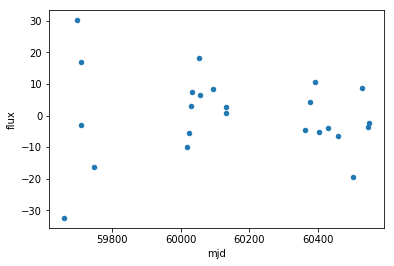

In [46]:
# now try to draw the pattern from time-series data, pick the first object from training dataset, 
# change the passband as you want
#all_90=mytrain[mytrain['target']==90]
all_65=mytrain[mytrain['target']==65]

# passband 0 flux in range -30~+50, for 90% of the data, true/false
# passband 1 flux in range -10~+100, or has a maximum very high from others, most of time is positive
# passband 2 flux in range -10~+300, some very high max, most of time is positive
# passband 3 flux, if not very high, the range is just around 30-40, not always positive
# passband 4, very likely to have high max, and with many local max, relatively volatile
# passband 5, some chance to have high max, and lox min, with many local max, relatively volatile
# for i in all_90.object_id.unique():
#     if mytrain_2[(mytrain_2['object_id']==i) & (mytrain_2['passband']==1)]['flux'].max()>200:
#         print(i)
#     print(mytrain_2[(mytrain_2['object_id']==i) & (mytrain_2['passband']==2)]['flux'].min())

#randobj=all_90.object_id.unique()[2]
#
randobj=all_65.object_id.unique()[2]
train_randobj_1=mytrain[(mytrain['object_id']==randobj) & (mytrain['passband']==3)]
train_randobj_1.head()
train_randobj_1.drop(['object_id','passband','flux_err','detected','target'],axis=1).plot(x='mjd',y='flux',kind='scatter')
plt.show()

In [36]:
def create_feature_max(timeseries, *args):
    passband_max=timeseries.groupby(['object_id','passband'],as_index=False)['flux'].max()
    for arg in args:
        res=passband_max[passband_max['passband']==arg]
        var="passband_"+str(arg)+"_max"
        res=res.rename(columns={"flux":var})
        yield res.drop(['passband'],axis=1)
# put the passband you want to calculate the max

    

In [37]:
def create_feature_min(timeseries,*args):
    passband_min=timeseries.groupby(['object_id','passband'],as_index=False)['flux'].min()
    for arg in args:
        res=passband_min[passband_min['passband']==arg]
        var="passband_"+str(arg)+"_min"
        res=res.rename(columns={"flux":var})
        yield res.drop(['passband'],axis=1)

In [38]:
def create_feature_quantile(timeseries,quan,*args):
    passband_quantile=timeseries.groupby(['object_id','passband'],as_index=False)['flux']\
    .quantile(quan,interpolation='lower').reset_index()
    passband_quantile.columns=['object_id','passband','quantile']
    passband_quantile['quantile']=passband_quantile['quantile'].round(6)
    res_list=[]
    for arg in args:
        res=passband_quantile[passband_quantile['passband']==arg]
        var="passband_"+str(arg)+"_"+str(quan*100)+"quantile"
        res=res.rename(columns={'quantile':var})
        yield res.drop(['passband'],axis=1)
#         return res.drop(['passband'],axis=1)

In [39]:
def create_peak_freq(timeseries, quantile, peak_direction):
    col=quantile.columns[1]
    passband=int(col.split('_')[1])
    objs=timeseries.object_id.unique()
    peak_freq=pd.DataFrame(columns=['object_id','peak_freq'])
    for obj in objs:
        tm=timeseries[(timeseries['object_id']==obj) &(timeseries['passband']==passband)]
        quan=quantile.loc[quantile['object_id']==obj,col].reset_index().drop(['index'],axis=1)
        quan=quan[col][0]
        df=peak_freq_helper(tm,peak_direction,quan)
        peak_freq=peak_freq.append(df)
    return peak_freq

In [40]:
def peak_freq_helper(tm,peak_direction,quan):
    if peak_direction=='positive':
#         keep object_id, mjd, and flux
        potential=tm[tm['flux']>=quan].drop(['target','flux_err','detected','time2'],axis=1)
        temp=peak_helper(potential)
        return temp
    else:
        potential=tm[tm['flux']<=quan].drop(['target','flux_err','detected','time2'],axis=1)
        return peak_helper(potential)

In [41]:
def peak_helper(potential):
    import copy
    # object_id, mjd, flux
    mat=potential.values
    # five days interval for peak
    mjd_thre=5
    data=[]
    if len(mat)==1:
        data.append(copy.deepcopy(mat[0]))
    else:
        for i in range(len(mat)):
            if i==0 and mat[i][2]>mat[i+1][2]:
                data.append(copy.deepcopy(mat[i]))
            elif i==len(mat)-1 and mat[i][2]>mat[i-1][2] and mat[i][1]-data[-1][1]>=mjd_thre:
                data.append(copy.deepcopy(mat[i]))
            elif i>0 and i<len(mat)-1 and mat[i][2]>mat[i-1][2] and mat[i][2]>mat[i+1][2] \
            and mat[i][1]-data[-1][1]>=mjd_thre:
                data.append(copy.deepcopy(mat[i]))
    res=[[mat[0][0],len(data)]]
    return pd.DataFrame(res,columns=['object_id','peak_freq'])
                
                

In [42]:
def add_features(timeseries,shrink, *args):
    idx=timeseries.object_id.unique()
    if shrink==None:
        shrink=pd.DataFrame()
        shrink['object_id']=pd.Series(idx)
#     create the new column value
    for arg in args:
        shrink=shrink.merge(arg,on='object_id',how='inner')
    return shrink

In [43]:
res1, res2=create_feature_max(mytrain,1,2)
res3, res4=create_feature_quantile(mytrain,0.9,1,2)
res5=create_peak_freq(mytrain,res1,'positive')
shrink_train=add_features(mytrain,None,res1,res2,res3,res4,res5)
res1, res2=create_feature_max(myval,1,2)
res3, res4=create_feature_quantile(myval,0.9,1,2)
shrink_val=add_features(myval,None,res1,res2,res3,res4)

In [30]:
label_train=mytrain.drop_duplicates('object_id').reset_index()
label_train=label_train.drop(['index','mjd','passband','flux','flux_err','detected','time2'],axis=1)
label_val=myval.drop_duplicates('object_id').reset_index()
label_val=label_val.drop(['index','mjd','passband','flux','flux_err','detected'],axis=1)

In [31]:
def transfrom_to_logistic_form(data,label,tar):
    data=pd.merge(data,label,how='inner',on=['object_id'])
    data['final_target']=[1 if x==tar else 0 for x in data['target']]
    data=data.drop(['target'],axis=1)
    data=data.rename(columns={"final_target":"target"})
    X=data.drop(['target','object_id'],axis=1)
    Y=data.loc[:,'target']
    return X,Y

In [32]:
X,Y=transfrom_to_logistic_form(shrink_train,label_train,90)
X_val,Y_val=transfrom_to_logistic_form(shrink_val,label_val,90)

In [35]:
X=X.values
X=np.mat(X)
Y=Y.values
X_val=X_val.values
X_val=np.mat(X_val)
Y_val=Y_val.values

AttributeError: 'matrix' object has no attribute 'values'

In [34]:
x,b=train(X2, Y2, alpha=0.001, n_epoch=100)

NameError: name 'train' is not defined

In [320]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',\
                         multi_class='multinomial').fit(X2, Y2)
clf.score(X_val,Y_val)

## Decision trees

In [ ]:
print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

## Random Forest

In [ ]:
X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X, y)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
print(clf.feature_importances_)
[0.14205973 0.76664038 0.0282433  0.06305659]
print(clf.predict([[0, 0, 0, 0]]))

## XGBoost